In [ ]:
# Load Dataset & Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("notebook")

df = pd.read_csv("../data/processed/final_train_features.csv")

print(df.shape)


(307511, 134)


In [ ]:
# Basic Data Sanity Checks

print(df.head())
print(df.info())
print(df.describe().T)

print("Is SK_ID_CURR unique?", df["SK_ID_CURR"].is_unique)
print("Is TARGET in df.columns?", "TARGET" in df.columns)




   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...   TOTAL_PAID POS_LOAN_COUNT POS_AVG_DPD POS_MAX_DPD POS_AVG_DPD_DEF  \
0  ...   219625.695            1.0    

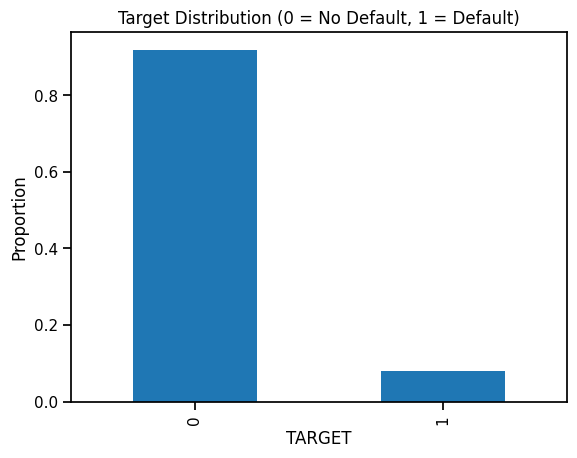

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [ ]:
# Target Variable Analysis (Class Imbalance)
# Distribution of Default vs Non-Default

target_dist = df["TARGET"].value_counts(normalize=True)

target_dist.plot(kind="bar")
plt.title("Target Distribution (0 = No Default, 1 = Default)")
plt.ylabel("Proportion")
plt.show()

target_dist




The dataset exhibits strong class imbalance, justifying stratified sampling and class-weighted models.

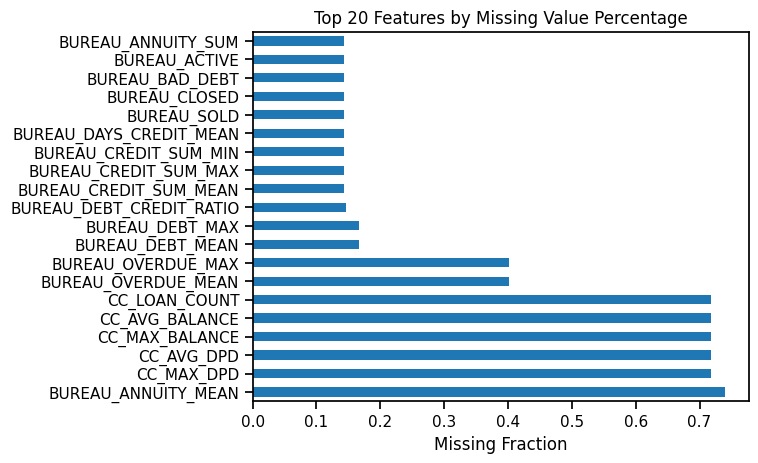

BUREAU_ANNUITY_MEAN         0.739817
CC_MAX_DPD                  0.718143
CC_AVG_DPD                  0.718143
CC_MAX_BALANCE              0.718143
CC_AVG_BALANCE              0.718143
CC_LOAN_COUNT               0.718143
BUREAU_OVERDUE_MEAN         0.402018
BUREAU_OVERDUE_MAX          0.402018
BUREAU_DEBT_MEAN            0.167083
BUREAU_DEBT_MAX             0.167083
BUREAU_DEBT_CREDIT_RATIO    0.146671
BUREAU_CREDIT_SUM_MEAN      0.143153
BUREAU_CREDIT_SUM_MAX       0.143153
BUREAU_CREDIT_SUM_MIN       0.143153
BUREAU_DAYS_CREDIT_MEAN     0.143149
BUREAU_SOLD                 0.143149
BUREAU_CLOSED               0.143149
BUREAU_BAD_DEBT             0.143149
BUREAU_ACTIVE               0.143149
BUREAU_ANNUITY_SUM          0.143149
dtype: float64

In [ ]:
# Missing Value Analysis

missing = (
    df.isna()
      .mean()
      .sort_values(ascending=False)
      .head(20)
)

missing.plot(kind="barh")
plt.title("Top 20 Features by Missing Value Percentage")
plt.xlabel("Missing Fraction")
plt.show()

missing


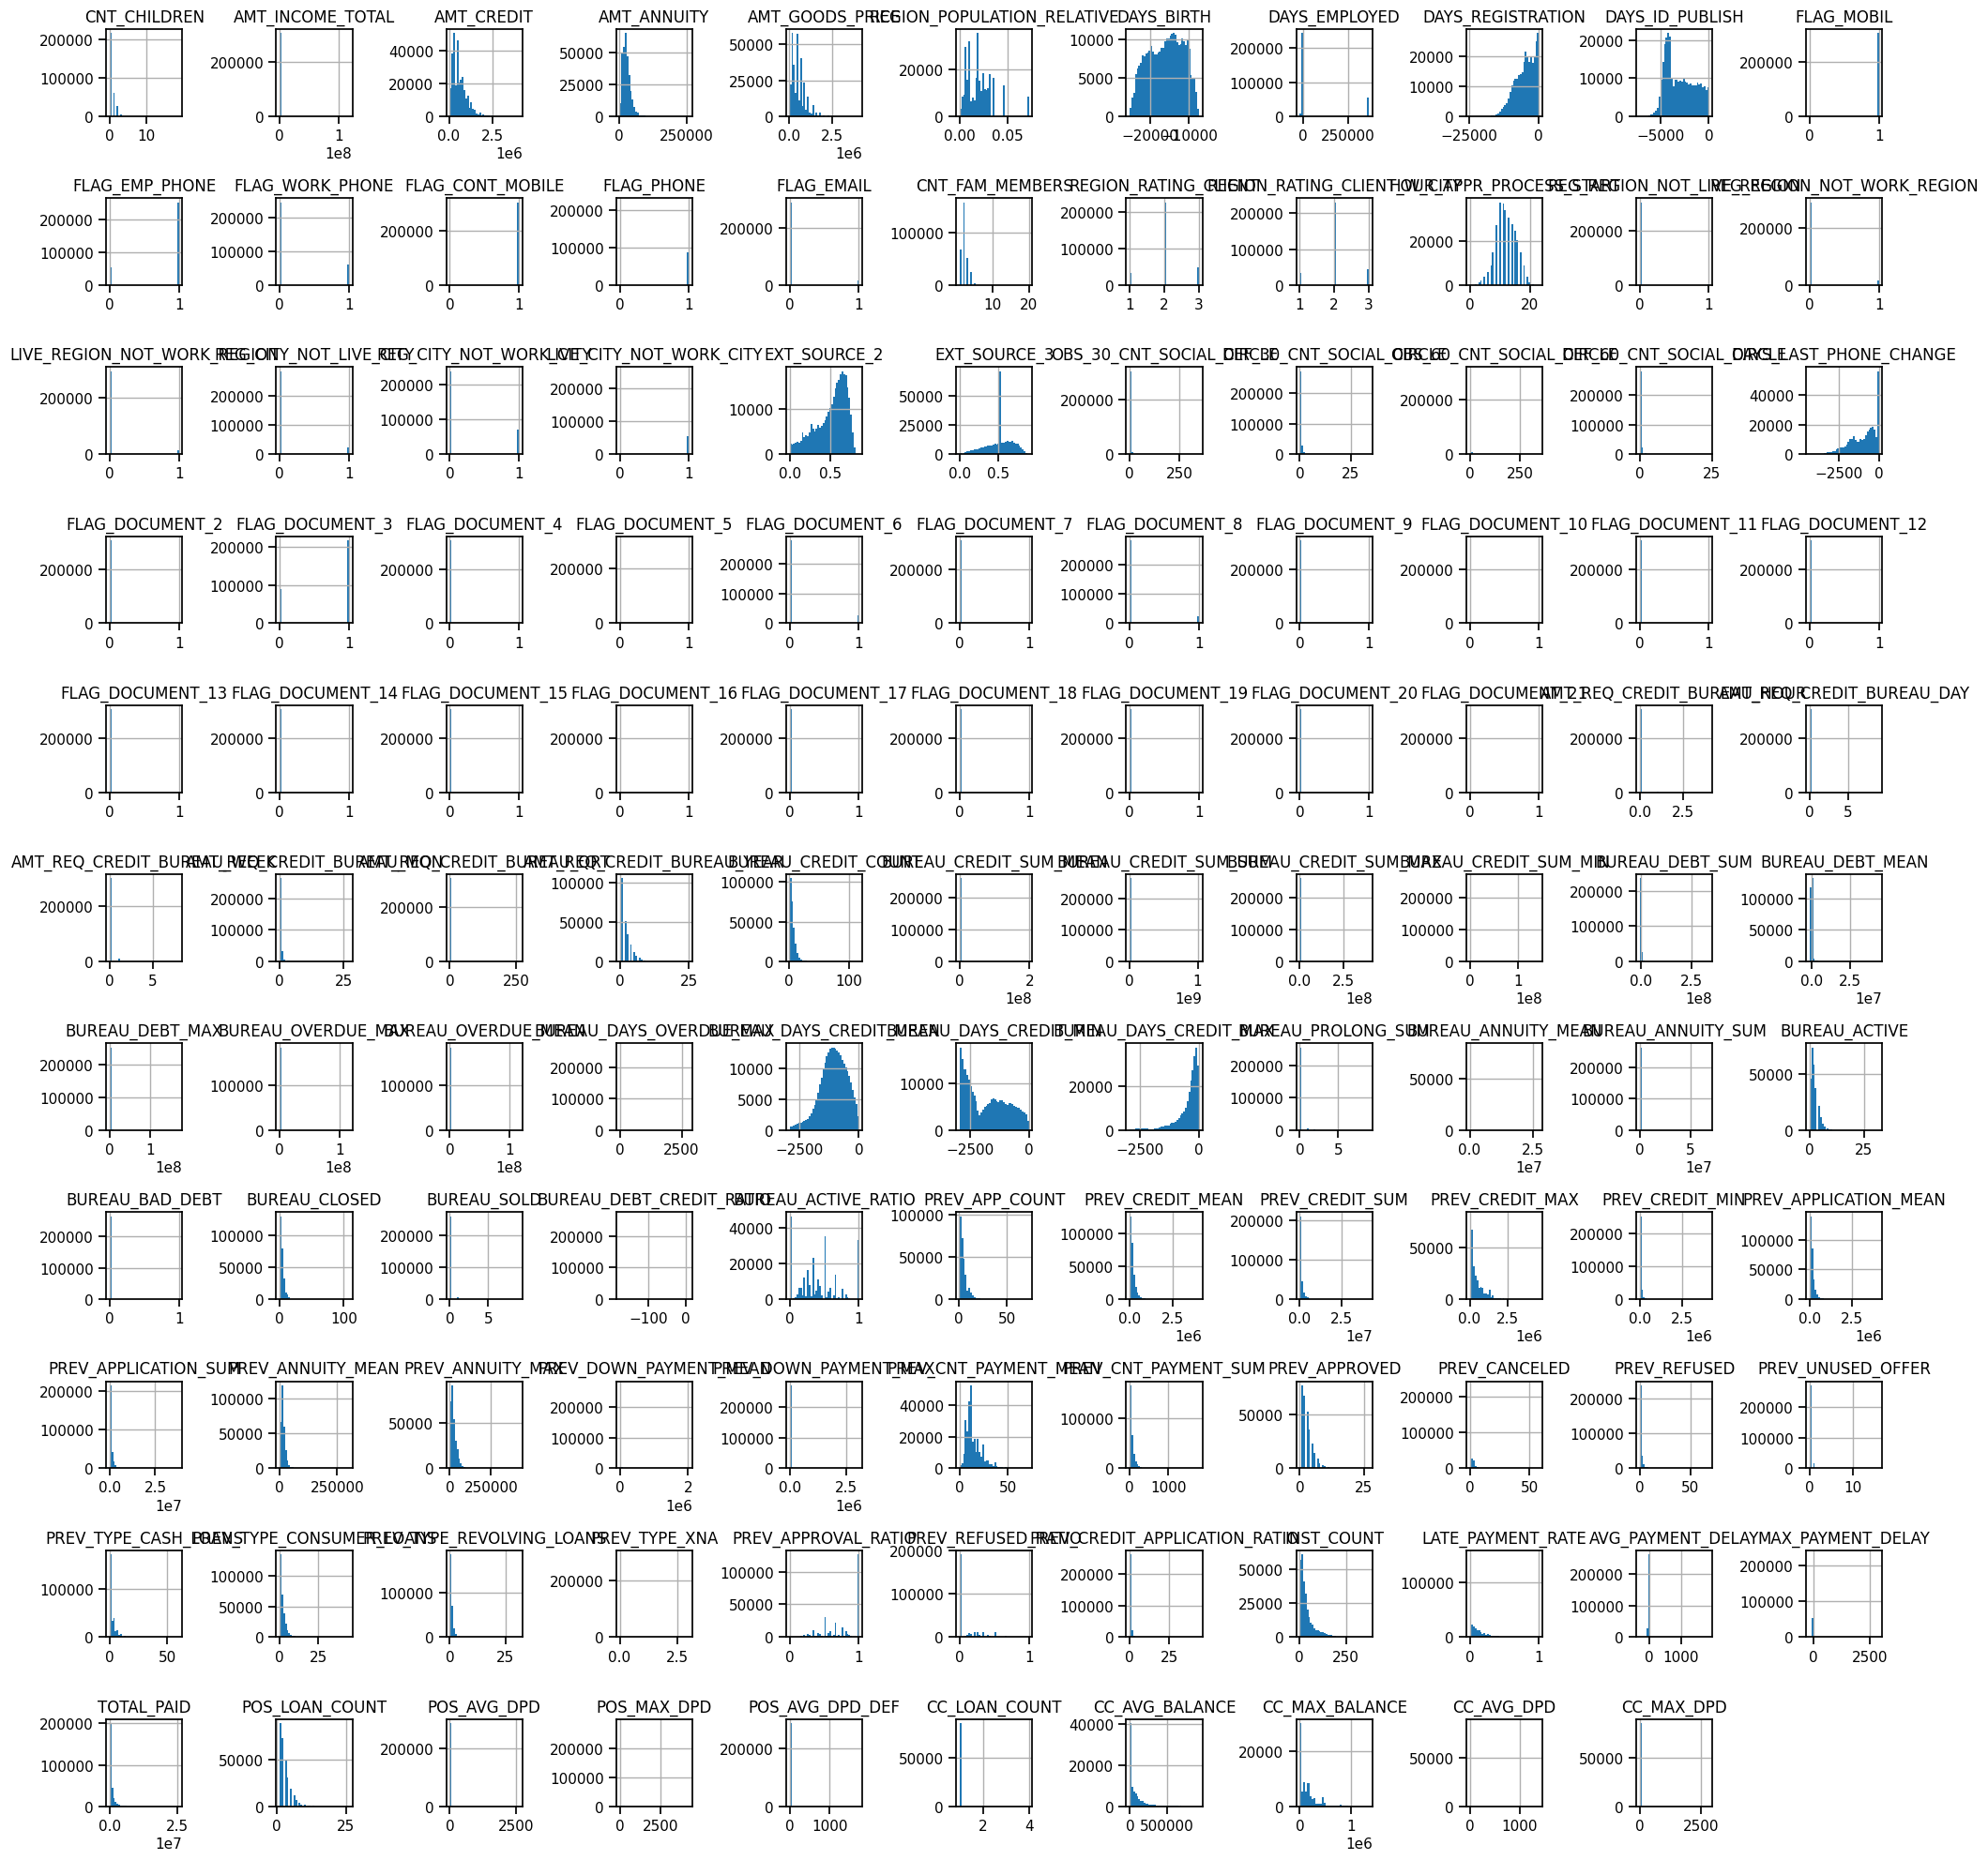

In [ ]:
# Feature Distribution Overview

numeric_features = df.drop(columns=["SK_ID_CURR", "TARGET"])

numeric_features.hist(
    bins=40,
    figsize=(20, 20)
)
plt.tight_layout()
plt.show()



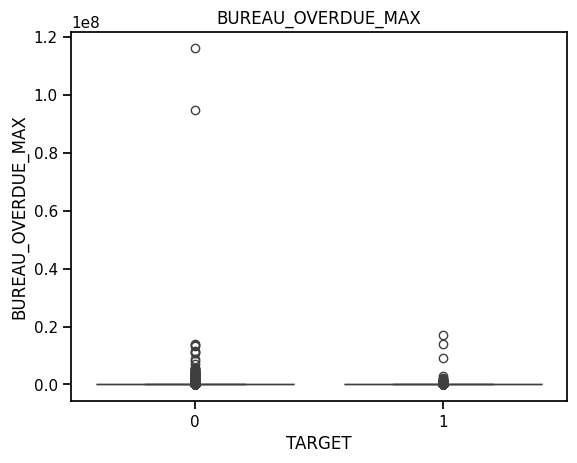

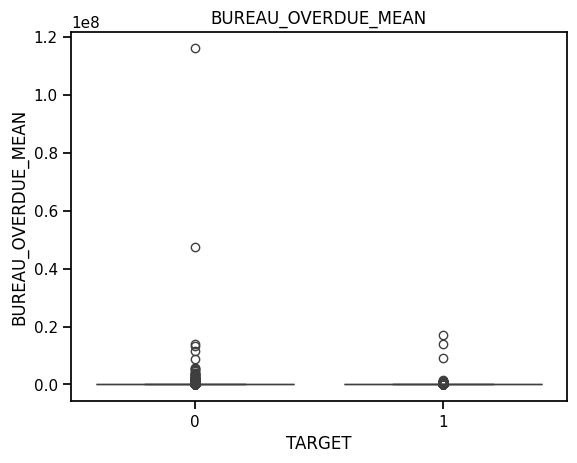

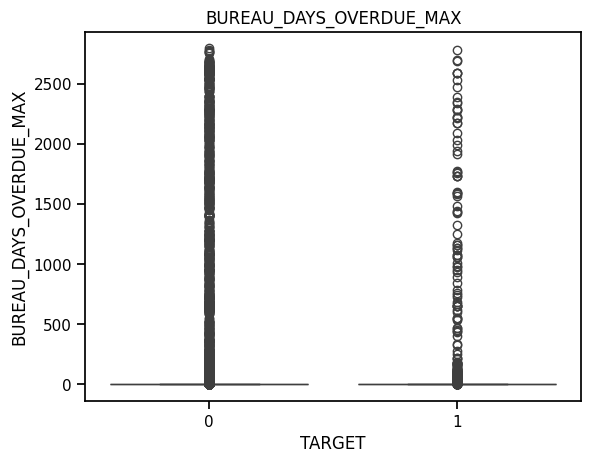

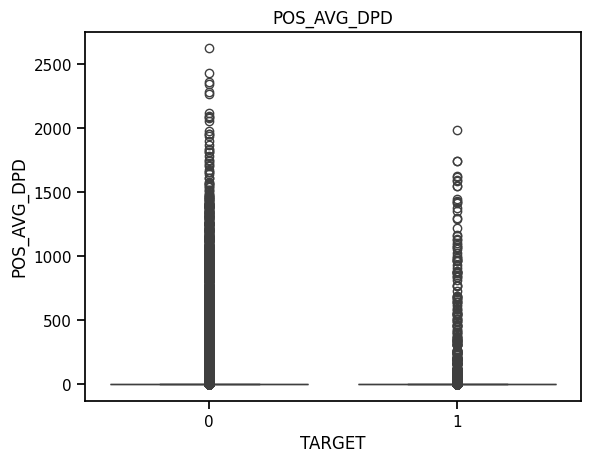

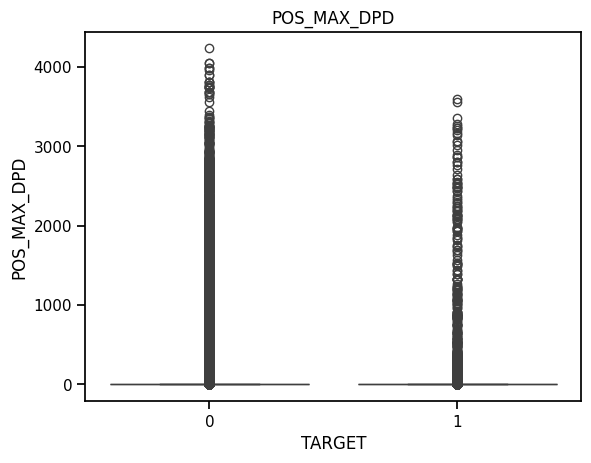

In [ ]:
# Feature vs Target Relationship
# Boxplots for Key Behavioral Features

key_features = [
    col for col in numeric_features.columns
    if "DPD" in col or "OVERDUE" in col
][:5]

for col in key_features:
    sns.boxplot(x="TARGET", y=col, data=df)
    plt.title(col)
    plt.show()



In [ ]:
# Identify non-numeric columns

df.dtypes.value_counts()

categorical_cols = df.select_dtypes(include=["object", "category"]).columns
categorical_cols



Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

In [ ]:
# Exclude categorical columns for correlation & multicollinearity

numeric_df = df.select_dtypes(include=["int64", "float64"])


In [ ]:
# Correlation Analysis

corr = numeric_df.corr()

corr_target = (
    numeric_df.corr()["TARGET"]
    .sort_values(ascending=False)
)

corr_target.head(10)


TARGET                     1.000000
BUREAU_DAYS_CREDIT_MEAN    0.089729
CC_AVG_BALANCE             0.086991
DAYS_BIRTH                 0.078239
PREV_REFUSED_RATIO         0.077671
BUREAU_ACTIVE_RATIO        0.077356
BUREAU_DAYS_CREDIT_MIN     0.075248
LATE_PAYMENT_RATE          0.070015
CC_MAX_BALANCE             0.068540
BUREAU_ACTIVE              0.067128
Name: TARGET, dtype: float64

In [ ]:
# Drop ID-like / non-informative columns

id_like_cols = [
    "SK_ID_CURR"
]

df = df.drop(columns=id_like_cols, errors="ignore")


In [ ]:
# Drop constant or near-constant features

from sklearn.feature_selection import VarianceThreshold

numeric_df = df.select_dtypes(include=["int64", "float64"]).drop(columns=["TARGET"])

selector = VarianceThreshold(threshold=0.0)
selector.fit(numeric_df)

low_variance_features = numeric_df.columns[
    ~selector.get_support()
]

low_variance_features

# drop low variance features

df = df.drop(columns=low_variance_features)




In [ ]:
# Drop features with extreme missingness

missing_ratio = df.isna().mean()

high_missing = missing_ratio[missing_ratio > 0.7].index
high_missing


Index(['BUREAU_ANNUITY_MEAN', 'CC_LOAN_COUNT', 'CC_AVG_BALANCE',
       'CC_MAX_BALANCE', 'CC_AVG_DPD', 'CC_MAX_DPD'],
      dtype='object')

In [ ]:
# Multicollinearity Check

# Handle multicollinearity

corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    column for column in upper.columns
    if any(upper[column] > 0.85)
]

high_corr_pairs

# Decide which one to keep (rules)

# For a correlated pair, 
# keep:
# MEAN over SUM
# RECENT over HISTORICAL
# DPD_MAX over DPD_MEAN
# Behavioral over demographic

# Drop:
# Redundant aggregates
# Multiple versions of same signal

redundant_features = [
    "INSTAL_DPD_SUM",
    "POS_DPD_SUM",
    "CREDIT_OVERDUE_SUM"
]

df = df.drop(columns=redundant_features, errors="ignore")


# Final sanity check
df.shape
df.isna().mean().max()


corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix.abs() > 0.8,
    cbar=False
)
plt.title("Highly Correlated Feature Pairs (>|0.8|)")
plt.show()





## EDA Summary

Key observations from post-feature-engineering EDA:

* The dataset is highly imbalanced, with a minority of applicants defaulting.
* Aggregated delinquency and payment behavior features show strong separation between default and non-default cases.
* Several features contain missing values due to incomplete credit histories, validating median imputation.
* Correlation analysis indicates potential multicollinearity, motivating the use of regularized or tree-based models.
